#**Different algorithms to train Biped Walker**



What we want to do in this project is to teach bipedal walker to walk with different strategies so that to be able to provide a comparison between genetic algorithms, evolutionary strategies and reinforcement learning techniques, both in a qualitatively and a quantitatively way.

Bipedal Walker environment is part of Open AI Gym and the main character is the robot portatried in the figure below. As we can see he has 2 legs, each one with 2 joints. He learns walking by applying the torque on his joints.

The dynamics of bipedal walker are deterministic but the terrain over which he walks is randomly generated at the beginning of each episode (we have fixed a specific seed at the beginning of the code in order to overcome this problem and to better reflections with the results obtained). Action and observation spaces are both continuous.

Some difficulties encountered by bipedal walker are due to the nonlinearity of the behavior of the robot as he tries to adeguate himself to different situations (ground contact, single leg contact and double leg contact), the uncertainty felt (terrain varies), the sparsity of the rewards and the partial observability (he can look ahead with lidar measurements but not behind).


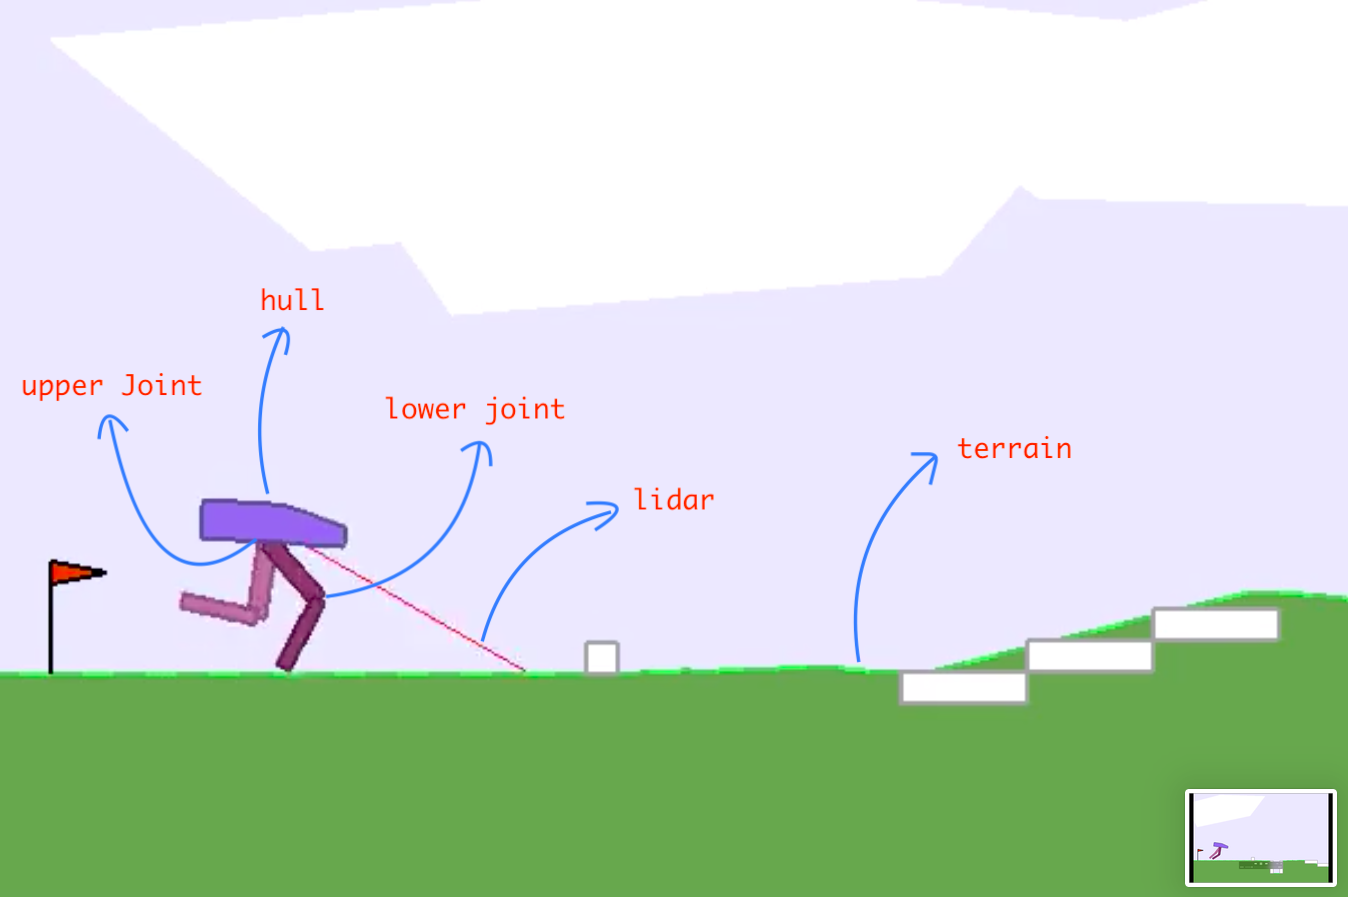

Bipedal Walker gets a positive reward proportional to the distance walked on the terrain. He can get a total of +300 all the way up to the end while, if he tumbles, he is penalized with -100.

There are some negative rewards proportional to the torque applied on the joint so that he learns to walk smoothly with minimal torque.

#**Algorithms implemented**

Index of algorithms implemented:


1.   Genetic Algorithm with feed-forward neural network;
2.   Genetic Algorithm with recurrent neural network;
3.   NEAT with feed-forward and recurrent neural network;
4.   CMA-ES;
5.   TD3.








## Refrences for githubs we have followed in our implementation.
* [GA refrence](https://github.com/robertjankowski/ga-openai-gym)
* [CMA-EA refrence](https://github.com/FeLusiani/Gym_Walker_CMA-ES)
* [NEAT refrence](https://github.com/Sentdex/NEAT-samples)
* [RF refrence 1](https://github.com/XinJingHao/TD3-Pytorch)
* [RF refrence 2](https://github.com/rlalpha/exploring-reinforcement-learning-methods)
* [RF refrence 3](https://pylessons.com/BipedalWalker-v3-PPO)
* [RF refrence 4](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#the-optimal-q-function-and-the-optimal-action)
* [RF refrence 5](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)
* [RF refrence 6](https://spinningup.openai.com/en/latest/algorithms/td3.html)

#**Codes**

**Installations and importations of necessary libraries**

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -U pyvirtualdisplay
!pip install -U gym>=0.21.0
!pip install -U gym[box2d,atari,accept-rom-license]
!pip install -U xvfbwrapper
!pip install -U cma
!pip install -U neat-python

import sklearn
import tensorflow as tf
import numpy as np
import os      
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gym
import pyvirtualdisplay
import time, math, random, bisect, copy
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from functools import partial
from itertools import product
import multiprocessing as mp
from multiprocessing import Pool
import cma
from pathlib import Path
from pandas.compat.numpy.function import MEDIAN_DEFAULTS
from collections import OrderedDict
from copy import deepcopy
import torch.distributions as tdist
from typing import Tuple, Any, List
import datetime
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import numpy.random as npr
import imageio
from collections import OrderedDict
from typing import Any
import multiprocessing
import pickle
import neat
from matplotlib.pylab import *
from neat.math_util import mean
from neat.reporting import ReporterSet
from neat.reproduction import DefaultReproduction
from neat.reporting import *
import warnings
warnings.filterwarnings("ignore")


In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False    
  import visualize
if IN_COLAB:
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/BIO_Project/Final_submission')
    import visualize


**Plotting graphs**

In [ ]:
#Fixing seeds and some parameters in order to overcome the randomness of the environment
import random
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('animation', html='jshtml')

#Plot environment
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

#Plot animations
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

#**Genetic Algorithm with feed-forward neural network**






Here we want to train a feed-forward neural network using a Genetic Algorithm. This algorithm replaces the common optimizers varying the weights and the biases of the neural network to obtain the best fitness value.
All the basic concepts of genetic algorithm are implemented: crossover, mutation, selection, repetition.
The fitness graph printed during training is determined by the rewards obtained by our biped walker. Reward is given for moving forward, 300 points up to the far end. When robot falls, it gets -100 points.

A note about the boolean parameter "complete".

By default it is set to false in order of not wasting time in training the network (the process takes about a day with our version of colab) and seeing directly the results corresponding to the best configuration found by us during training.
Setting it to true the whole code will be run.

**Code**

##**Global variables**

In [ ]:
#Global variables

game = 'BipedalWalker-v3'
env = gym.make(game)
observation = env.reset()
population_size = 30
number_of_generations =2000
date = datetime.datetime.now().strftime('%m-%d-%Y_%H-%M-%S')
path_ff = 'BipedalWalker_FeedForward/'
max_of_ever=-10e6
number_of_steps=1000                                                  
number_of_runs = 100
input_size = 24
hidden_size=[20, 12, 12]
output_size = 4
batch_size_dim = 16
number_of_epochs = 16
probability_of_mutation=0.6
probability_of_crossover=0.85
complete=False
prog_ftnss= 0.0
evaluate=0

##**MLP with 3 hidden layers**

In [ ]:
#Definition of my neural network class
class MyNN(nn.Module):

    def __init__(self, input_size, output_size, *hidden_sizes):
        super(MyNN, self).__init__()
        assert len(hidden_sizes) >= 1
        self.input_size = input_size
        self.output_size = output_size
        self.linear_layers = nn.ModuleList()
        for in_size, out_size in zip([input_size] + [*hidden_sizes], [*hidden_sizes] + [output_size]):
            self.linear_layers.append(nn.Linear(in_size, out_size))

    def forward(self, x):
        output = x
        for layers in self.linear_layers[:-1]:
            output = layers(output)
        return torch.tanh(self.linear_layers[-1](output))
   
    def update_weights_biases(self, weights_biases: np.array):
        weights_biases = torch.from_numpy(weights_biases)
        dictionaries = [x.shape for x in self.state_dict().values()]
        dictionaries_prod = [torch.tensor(s).numpy().prod() for s in dictionaries]

        partial_split = weights_biases.split(dictionaries_prod)
        model_weights_biases = []
        for i in range(len(dictionaries)):
            model_weights_biases.append(partial_split[i].view(dictionaries[i]))
        state_dict = OrderedDict(zip(self.state_dict().keys(), model_weights_biases))
        self.load_state_dict(state_dict)
     
    def load(self, file):
        self.update_weights_biases(np.load(file))

##**Setup of the display**

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
env.render()

##**Class that defines my single individual (bipedal walker)**

Note that each individual corresponds to a particular neural network with specific values of the weights. These weights are what distinguish individuals between each other.

In this class all the different methods are implemented.

In [ ]:
class Individual:

    def __init__(self, model=None):
        if model is not None:
            self.model = model
        else:
            dim_input, H, dim_output = input_size, hidden_size, output_size
            self.model = MyNN(dim_input, dim_output, *H)
        self.fitness = 0.0
        self.weights_biases = None
        self.frames=[]

    def calculate_fitness(self) :
        self.fitness, self.weights_biases, self.frames, self.step = learn_walking(self.model)

    def update_model(self):
      
        #Update weights and biases of my model. This function transforms the list of model parameters to state dict
        #State_dict objects are Python dictionaries that can be easily saved, updated, altered, and restored

        dictionaries = [x.shape for x in self.model.state_dict().values()]
        dictionaries_prod = [torch.tensor(s).numpy().prod() for s in dictionaries]
        partial_split = self.weights_biases.split(dictionaries_prod)
        model_values = []
        for i in range(len(dictionaries)):
          model_values.append(partial_split[i].view(dictionaries[i]))
        state_dict = OrderedDict((key, value) for (key, value) in zip(self.model.state_dict().keys(), model_values))
        self.model.load_state_dict(state_dict)

##**Learn walking**

Funtion that calculates the fitness function for an individual of the population. Decides the action bipedal walker has to undertake and computes fitness for that specific action.

Bipedal walker keeps walking until he falls.

In [ ]:
def learn_walking(model, number_of_steps=1, render=True):
    obs = env.reset()
    fitness = 0

    #List of frames in order to recreate the scene
    frames=[]
    n_step = 0
    
    for st in range(number_of_steps):
        if render:
            #Creation of my image
            img = env.render(mode="rgb_array")
            frames.append(img)
        obs = torch.from_numpy(obs).float()
        action = model(obs)
        action = action.detach().numpy()

        #Obs are environment-specific object, rewards are the rewards received after each action and used to caluclate the fitness, done tells when it is about time to reset the environment, info are information useful for the debugging
        obs, reward, done, info = env.step(action)
        
        fitness += reward
        n_step += st
        if done:
            break
    env.close()

    #Get model parameters (weights and biases) and concatenate them
    parameters = model.state_dict().values()
    parameters = [x.flatten() for x in parameters]
    parameters = torch.cat(parameters, 0)
    weight_biases = parameters

    #Return a tensor with all weights and biase and a np array for the creation of the animation
    return fitness, weight_biases, frames,n_step

##**Roulette-wheel selection**

Here is reported the selection strategy adopted: Roulette-wheel selection.

The probability that an individual makes an offspring is proportional to how good its fitness is with respect to the population fitness:

p(i) = f(i)/Σf(i), where i is the individual index.

Related problems to this method:
1.   Fitness must be non-negative;
2.   Fitness values are too close;
3.   Few high-fitness individuals implies an high selection pressure.



In [ ]:
#Roulette-wheel selection to pick random individuals from the population

def roulette_wheel_selection(population: List[Individual]):
    minimum=np.min([c.fitness for c in population])
    total_fit = np.sum([(c.fitness-minimum) for c in population])
    selection_probs = [(c.fitness-minimum)/total_fit for c in population]
    pick = np.random.choice(len(population), p=selection_probs)
    return population[pick]

##**New generations**

Here we can find the concepts of the creation of a population, of the replacement method used (elitism), of mutation and of crossover.

Replacement-> random choice of two different individuals which are subject to mutations and crossover. Then fitness is calculated for both of them. Finally they are compared with parents and the two fittest individuals are kept. This process continues until all population has been examined.

In [ ]:
#Creation of my new generation

def create_population(old_population, new_population):
    res_old_pop=roulette_wheel_selection(old_population)
    for i in range(0, len(old_population) - 1, 2):
        parent1 = roulette_wheel_selection(old_population)
        parent2 = roulette_wheel_selection(old_population)
        while(parent1==parent2):
          parent2 = roulette_wheel_selection(old_population)

        #Application of cross-over
        
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        
        if np.random.rand() < probability_of_crossover:

          position = np.random.randint(0, parent1.weights_biases.shape[0])
          child1.weights_biases = parent1.weights_biases.clone()
          child2.weights_biases = parent2.weights_biases.clone()

          tmp = child1.weights_biases[:position].clone()
          child1.weights_biases[:position] = child2.weights_biases[:position]
          child2.weights_biases[:position] = tmp

        #Application of mutation using normal distribution
  
        child_weight_biases = child1.weights_biases.clone()
        if np.random.rand() < probability_of_mutation:
          position = np.random.randint(0, child1.weights_biases.shape[0])
          n = tdist.Normal(child_weight_biases.mean(), child_weight_biases.std())
          child_weight_biases[position] = 5 * n.sample() + np.random.randint(-20, 20)
        child1.weights_biases = child_weight_biases

        child_weight_biases = child2.weights_biases.clone()
        if np.random.rand() < probability_of_mutation:
          position = np.random.randint(0, child2.weights_biases.shape[0])
          n = tdist.Normal(child_weight_biases.mean(), child_weight_biases.std())
          child_weight_biases[position] = 5 * n.sample() + np.random.randint(-20, 20)
        child2.weights_biases = child_weight_biases
        
        # Update model weights and biases
        child1.update_model()
        child2.update_model()

        #Calculation of fitness for new individuals
        child1.calculate_fitness()
        child2.calculate_fitness()

        #We take the two best individuals among parents and children looking at their fitness
        fitness_list=[(child1.fitness, child1),  (child2.fitness, child2), (parent1.fitness, parent1), (parent2.fitness, parent2)]
        fitness_list.sort(key= lambda fitness_list: fitness_list[0], reverse=True)
        new_population[i] = fitness_list[0][1]
        new_population[i + 1] = fitness_list[1][1]


##**Statistics**

In this part we also collect statistics related to fitness so as to plot them in a graph.

On y axis indexes of statistics of fitness are plotted in relation to a population of each generation.

You can choose which one to plot between min, max, average, median, max of ever, or all of them.

These data are also saved in a specific csv file, as well as the best individual ever.

In [ ]:

if complete:

  #Definition of previous population
  old_population = [Individual() for _ in range(population_size)]

  #Allocation of next generation
  new_population = [None] * population_size

  #Searching the fittest biped walker to be added in population
  max_of_ever=-10e6
  best_model = Individual()
  best_model.fitness = -10e6
  best_x_gen = []
  grafico = np.empty((0,6))
  for gen in range(number_of_generations):
        [p.calculate_fitness() for p in old_population]
        create_population(old_population, new_population)
        population= list(new_population)
        population_fitness = list(map(lambda individual: individual.fitness, population))
        population_step = list(map(lambda individual: individual.step, population))


        #Calculation of statistics
        mean = np.mean(population_fitness)
        std = np.std(population_fitness)
        min = np.min(population_fitness)
        max = np.max(population_fitness) 
        median = np.median(population_fitness)
        max_of_ever=(max if max > max_of_ever else max_of_ever)

        max_step = np.max(population_step) 
        min_step= np.min(population_step)

        #Collect data to be later plot in a graph
        grafico = np.append(grafico, np.array([[mean,std,min,max,max_of_ever,median]]), axis=0)

        #Updating population
        old_population = deepcopy(new_population)
        print(f'Gen: {gen}\tMax step: {max_step}\tMin step: {min_step}\tMean: {mean}\tmin: {min}\tmax: {max}\n')
        tmp = sorted(new_population, key=lambda individual: individual.fitness, reverse=True)[0]
        #Updating best per generation
        best_x_gen.append(tmp.weights_biases)
        #Updating best biped walker
        if  tmp.fitness > best_model.fitness:
          best_model = tmp

  #Plotting the graph
  ascissa=np.arange(number_of_generations)
  #plt.plot(ascissa, grafico[:,[0,1,3]])
  plt.plot(ascissa, grafico[:,[0]], "-b", label="average")
  plt.plot(ascissa, grafico[:,[2]], "-k", label="worst")
  plt.plot(ascissa, grafico[:,[3]], "-r", label="best")
  plt.legend(loc="center")
  plt.xlabel("Generations)")
  plt.ylabel("Fitness")
  plt.show()
  
  #Saving data into a csv file
  stat_data=pd.DataFrame(data=grafico[0:,0:], 
                         index=[i for i in range(grafico.shape[0])], 
                         columns={'mean':grafico[:,0],
                                  'std':grafico[:,1],
                                  'worst':grafico[:,2],
                                  'best':grafico[:,3],
                                  'best ever':grafico[:,4],
                                  'median':grafico[:,5]})
 
  file_name= 'FFNet.csv'
  stat_data.to_csv(path_ff+file_name)      

  #Save best model x generation found
  file_name='bestXgen'
  best_x_gen=np.array(best_x_gen)
  np.save(path_ff + file_name, best_x_gen)

  #Save best model (best indiviual) found
  file_name='MyBest' 
  np.save(path_ff+file_name, best_model.weights_biases)
  env.close()

  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
  env.reset()

  model1 = MyNN(input_size, output_size, hidden_size)
  model1.update_weights_biases(best_model.weights_biases)

  d,e,f,s=learn_walking(model1, number_of_steps=10, render=True)


##**Merging the two graphs together**

In [ ]:
ascissa=np.arange(number_of_generations)
stat_data=pd.read_csv(path_ff + 'FFNet.csv')
best_av=pd.read_csv(path_ff+'Best_average.csv')
grafico=stat_data.to_numpy()
best=best_av.to_numpy()
plt.plot(ascissa, grafico[:,[1]], "-b", label="Average")
plt.plot(ascissa, grafico[:,[3]], "-k", label="Worst")
plt.plot(ascissa, grafico[:,[4]], "-r", label="Best")
plt.plot(ascissa, best[:,[1]], "-g", label="Best_avg")
plt.legend(loc="center")
plt.xlabel("Generations)")
plt.ylabel("Fitness")
plt.show()


##**Trained model**

Here we see the results of the code on an already trained model (the best that we have found in our experiments).



In [ ]:
#Set parameter corresponding to the best model found
env = gym.make('BipedalWalker-v3')
number_of_runs = 20
INPUT_SIZE = 24
HIDDEN_SIZE = [20, 12, 12]
OUTPUT_SIZE = 4
N_RUNS=10

##**Learn walking, best model**

Function similar to "learn_walking". Here we want also to save features and labels of our reference
model.

We will use them in the functions below.

In [ ]:
#This time we pass just the model and the environment, we do not need runs as model has already been trained.
#We upload the related weights

def single_run(env, model, render=False):
    obs = env.reset()
    features = []
    labels = []
    frames=[]
    fitness = 0.0
    while True:
        if render:
            env.render()
            #Creation of my image
            img = env.render(mode="rgb_array")
            frames.append(img)
        features.append(obs)
        obs = torch.from_numpy(obs).float()
        action = model.forward(obs).detach().numpy()
        labels.append(action)
        obs, reward, done, _ = env.step(action)
        fitness += reward
        if done:
            break
    #Features lenght has to be the same of inputs lenght     
    assert len(features) == len(labels)
    return features, labels,frames,fitness

##**Best individual for each generation**

Here we have performed 10 test episodes for the best individual in each generation, and then averaged the test results in order to represent the performance at those time steps. We have used linear interpolation for the average statistics across the different runs.

In [ ]:
#Loading of the model file containg the model corresponding to the best model of each generation
if complete:
  model_file='best_x_gen.npy'
  best_x_gen=np.load(path_ff+model_file)
  file_name='Best_average'
  best_test=np.empty((0,1))
  for j in range(best_x_gen.shape[1]):
    model3 = MyNN(INPUT_SIZE, OUTPUT_SIZE, *HIDDEN_SIZE)
    model3.update_weights_biases(best_x_gen[:,j])
    prog_fit = 0.0
    for i in range(N_RUNS):
      env.seed(i)
      features, labels, frames, fitness = single_run(env, model3)
      prog_fit+=fitness
    best_test=np.append(best_test,[[prog_fit/N_RUNS]], axis=0)

  #Save data
  np.save(path_ff+file_name, best_test)

  #Plotting the graph
  ascissa=np.arange(best_x_gen.shape[1])
  plt.plot(ascissa, best_test[:,[0]], "-b", label="Best average")
  plt.legend(loc="upper left")
  plt.xlabel("Generations")
  plt.ylabel("Fitness")

  env.close()

##**Converting numpy file into csv for the graph**

In [ ]:
file_name='Best_average.npy'
best_test=np.load(path_ff+file_name)
df=pd.DataFrame(best_test, columns=['Average'])
df.to_csv(path_ff+'Best_average.csv')


##**Best model of ever**

Here we use the parameters and weights of the best individual of all that we have previously saved.

In [ ]:
#Loading of the numpy file containg the weights corresponding to the reference model
model_file='reference-model.npy'
model2 = MyNN(INPUT_SIZE, OUTPUT_SIZE, *HIDDEN_SIZE)
model2.load(path_ff+model_file)
if complete:
  output_file = "data_reference-model.csv"
  features_output_file =path_ff + "features_" + output_file
  labels_output_file = path_ff +"labels_" + output_file

  #We write down into a file the labels and features of the best model as a target for my reference model
  with open(features_output_file, 'w') as f_features, open(labels_output_file, 'w') as f_labels:
         for i in range(N_RUNS):
            env.seed(i)
            features, labels, frames, fitness = single_run(env, model2)
            for f, l in zip(features, labels):
                f_features.write(','.join(map(str, f)) + '\n')
                f_labels.write(','.join(map(str, l)) + '\n')


  env.close()

##**Student-teacher**

In this part we have hinted towards the technique "student-teacher" from unsupervised domain adaptation. The objective is to improve a new model referring it to the best found before.

A student network (new model to be trained) is introduced to learn the target-specific feature space from a teacher network (best model previously found).

Both teacher and student networks compete to provide target pseudo-labels to constrain every target sample's training in student network.

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [ ]:
#Plotting of the frames previously collected for the best model
a,b,c,_=single_run(env, model2, render=True)
if complete:

  #Here we want to compare models between each other. In order to do this we use features and labels previously calculated
  #and through them we compute the losses.

  def train(train_data, model, opt, loss_func, epochs):
    min_loss = 10e6
    for epoch in range(epochs):
        for xb, yb in train_data:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        new_min_loss = loss_func(student_model(xb), yb)
        if new_min_loss < min_loss:
            min_loss = new_min_loss
            torch.save(student_model,
                       path_ff + "model-layers={}-[{}]-{}-NN=StudentModel-EPOCH={}_LOSS={}.pt".format(
                       INPUT_SIZE, ','.join(map(str, HIDDEN_SIZE)), OUTPUT_SIZE, epochs, min_loss))
        print('Epoch {}: loss = {}'.format(epoch, min_loss))

  #Reading features and labels files of reference model previously found
  X = pd.read_csv(path_ff + "features_data_reference-model.csv", header=None)
  y = pd.read_csv(path_ff + "labels_data_reference-model.csv", header=None)

  #Converting inputs and targets into tensors
  X = torch.tensor(X.values, dtype=torch.float)
  y = torch.tensor(y.values, dtype=torch.float)

  #Creating dataset and datoloader classes reading labels and feature of reference model previously found
  train_ds = TensorDataset(X, y)
  train_dl = DataLoader(train_ds, batch_size=batch_size_dim, shuffle=True)

  #Model we want to train using the refernce one
  model_file = 'MyBest.npy'
  student_model=MyNN(input_size,output_size, *hidden_size)
  np.load(path_ff + model_file,allow_pickle=True)

  #Adam optimizer
  opt=torch.optim.Adam(student_model.parameters(), lr=1e-3)

  #Mean Square Error Loss Function
  loss_func = nn.modules.loss.MSELoss(size_average=False)

  #Training my model
  train(train_dl, student_model, opt, loss_func, number_of_epochs)




##**Animation**

Final plot of bipedal walker.

In [ ]:
if complete:
  biped=plot_animation(f)
else:
  biped=plot_animation(c)

biped

##**Saving animation**

In [ ]:
#Save animation
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image
writergif = animation.PillowWriter(fps=30) 
biped.save(path_ff + 'animation.gif', writer=writergif)

#**Genetic Algorithm with Recurrent Neural Network**

The code is almost equal to the one above, just the neural network has recurrent connections.

As expected this neural network is not suited for this kind of problem as it is not sequential. On the contrary, in this case recurrent connections tend to overcomplicate the scenario resulting in worse results.

For this reason we have just reported the code of the training. The following part of plotting the best model would have been exactly the same one of the feed-forward but in this case, as the maximum fitness score reached was about 9, bipedal walker would have fallen immediately.

**Code**

##**Definition of global variables**

In [ ]:
#Global variables

game = 'BipedalWalker-v3'
env = gym.make(game)
observation = env.reset()
population_size = 30
number_of_generations = 2000 
date = datetime.datetime.now().strftime('%m-%d-%Y_%H-%M-%S')
path = 'BipedalWalker_RRNet/'
number_of_steps= 1000                                                  
number_of_runs = 100
input_size = 24
hidden_size1 = 24
hidden_size2 = 12
output_size = 4
batch_size_dim = 16
number_of_epochs = 16
probability_of_mutation=0.2
probability_of_crossover=0.9
complete=False

##**Recurrent Neural Network with two hidden layers**

In [ ]:
from collections import OrderedDict
from typing import Tuple

import numpy as np
import torch.nn as nn
import torchgen


class MyNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MyNN, self).__init__()
        self.hidden_size1 = hidden_size1

        self.i2h = nn.Linear(input_size + hidden_size1, hidden_size2)
        self.hidden_combined_layer = nn.Linear(hidden_size2, hidden_size1)
        self.output_combined_layer = nn.Linear(hidden_size2, output_size)

    def forward(self, input, hidden) -> Tuple[torch.Tensor, torch.Tensor]:
        combined = torch.cat((input, hidden), 0)
        combined = torch.relu(self.i2h(combined))
        hidden = self.hidden_combined_layer(combined)
        output = nn.Tanh()(self.output_combined_layer(combined))
        return output, hidden

    def init_hidden(self) -> torch.Tensor:
        return torch.zeros(self.hidden_size1)

    def get_weights_biases(self) -> np.array:
        parameters = self.state_dict().values()
        parameters = [p.flatten() for p in parameters]
        parameters = torch.cat(parameters, 0)
        return parameters.detach().numpy()

    def update_weights_biases(self, weights_biases: np.array):
        weights_biases = torch.from_numpy(weights_biases)
        shapes = [x.shape for x in self.state_dict().values()]
        shapes_prod = [torch.tensor(s).numpy().prod() for s in shapes]

        partial_split = weights_biases.split(shapes_prod)
        model_weights_biases = []
        for i in range(len(shapes)):
            model_weights_biases.append(partial_split[i].view(shapes[i]))
        state_dict = OrderedDict(zip(self.state_dict().keys(), model_weights_biases))
        self.load_state_dict(state_dict)

    def load(self, file):
        self.update_weights_biases(np.load(file, allow_pickle=True))


##**Setup of the display**

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
env.render()

##**Class that defines my single biped walker**

In [ ]:
#Class that defines my single individual

class Individual:

    def __init__(self, model=None):
        if model is not None:
            self.model = model
        else:
            dim_input, H1, H2, dim_output = input_size, hidden_size1, hidden_size2, output_size
            self.model = MyNN(dim_input, H1, H2, dim_output)
        self.fitness = 0.0
        self.weights_biases = None
        self.frames=[]
        self.step = 0
 
    def calculate_fitness(self) :
        self.fitness, self.weights_biases, self.frames, self.step = learn_walking(self.model)

    def update_model(self):
        #Update weights and biases of my model. This function transforms the list of model parameters to state dict
        #State_dict objects are Python dictionaries that can be easily saved, updated, altered, and restored
        dictionaries = [x.shape for x in self.model.state_dict().values()]
        dictionaries_prod = [torch.tensor(s).numpy().prod() for s in dictionaries]
        partial_split = self.weights_biases.split(dictionaries_prod)
        model_values = []
        for i in range(len(dictionaries)):
          model_values.append(partial_split[i].view(dictionaries[i]))
        state_dict = OrderedDict((key, value) for (key, value) in zip(self.model.state_dict().keys(), model_values))
        self.model.load_state_dict(state_dict)

##**Calculation of actions to undertake and rewards for a chosen individual**

In [ ]:
#Funtion that calculates the fitness function for a specific model
def learn_walking(model, number_of_steps=1000, render=True):
  
    obs = env.reset()
    fitness = 0
    n_step = 0
    frames=[]
    hidden = model.init_hidden()
    for st in range(number_of_steps):
    #st = 0
    #while True:
        if render:
            #Creation of my image
            img = env.render(mode="rgb_array")
            frames.append(img)
        obs = torch.from_numpy(obs).float()
        action, hidden =model.forward(obs, hidden)
        action = action.detach().numpy()
        action = np.nan_to_num(action)
        #Obs are environment-specific object, rewards are the rewards received after each action and used to caluclate the fitness, done tells when it is about time to reset the environment, info are information useful for the debugging
        obs, reward, done, info = env.step(action)
        fitness += reward
        n_step +=1
        if done:
            break
    env.close()
    
    #Get model parameters (weights and biases) and concatenate them
    parameters = model.state_dict().values()
    parameters = [x.flatten() for x in parameters]
    parameters = torch.cat(parameters, 0)
    weight_biases = parameters
    #Return a tensor with all weights and biase and a np array for the creation of the animation
    return fitness, weight_biases, frames, n_step

##**Selection method**

In [ ]:
#Roulette-wheel selection to pick random individuals from the population

def roulette_wheel_selection(population: List[Individual]):
    minimum=np.min([c.fitness for c in population])
    total_fit = np.sum([(c.fitness-minimum) for c in population])
    selection_probs = [(c.fitness-minimum)/total_fit for c in population]
    pick = np.random.choice(len(population), p=selection_probs)
    return population[pick]

##**New population, crossover and mutation, statistics**

In [ ]:
#Creation of my new generation

def create_population(old_population, new_population):
    res_old_pop=roulette_wheel_selection(old_population)
    for i in range(0, len(old_population) - 1, 2):
        parent1 = roulette_wheel_selection(old_population)
        parent2 = roulette_wheel_selection(old_population)
        while(parent1==parent2):
          parent2 = roulette_wheel_selection(old_population)

        #Application of cross-over
        
        child1 = copy.deepcopy(parent1)
        child2 = copy.deepcopy(parent2)
        
        if np.random.rand() < probability_of_crossover:

          position = np.random.randint(0, parent1.weights_biases.shape[0])
          child1.weights_biases = parent1.weights_biases.clone()
          child2.weights_biases = parent2.weights_biases.clone()

          tmp = child1.weights_biases[:position].clone()
          child1.weights_biases[:position] = child2.weights_biases[:position]
          child2.weights_biases[:position] = tmp

        #Application of mutation using normal distribution
  
        child_weight_biases = child1.weights_biases.clone()
        if np.random.rand() < probability_of_mutation:
          position = np.random.randint(0, child1.weights_biases.shape[0])
          n = tdist.Normal(child_weight_biases.mean(), child_weight_biases.std())
          child_weight_biases[position] = 5 * n.sample() + np.random.randint(-20, 20)
        child1.weights_biases = child_weight_biases

        child_weight_biases = child2.weights_biases.clone()
        if np.random.rand() < probability_of_mutation:
          position = np.random.randint(0, child2.weights_biases.shape[0])
          n = tdist.Normal(child_weight_biases.mean(), child_weight_biases.std())
          child_weight_biases[position] = 5 * n.sample() + np.random.randint(-20, 20)
        child2.weights_biases = child_weight_biases
        
        # Update model weights and biases
        child1.update_model()
        child2.update_model()

        #Calculation of fitness for new individuals
        child1.calculate_fitness()
        child2.calculate_fitness()

        #We take the two best individuals among parents and children looking at their fitness
        fitness_list=[(child1.fitness, child1),  (child2.fitness, child2), (parent1.fitness, parent1), (parent2.fitness, parent2)]
        fitness_list.sort(key= lambda fitness_list: fitness_list[0], reverse=True)
        new_population[i] = fitness_list[0][1]
        new_population[i + 1] = fitness_list[1][1]

In [ ]:
import copy
from copy import deepcopy

from pandas.compat.numpy.function import MEDIAN_DEFAULTS
if complete:

  #Definition of previous population
  old_population = [Individual() for _ in range(population_size)]

  #Allocation of next generation
  new_population = [None] * population_size

  #Searching the fittest biped walker to be added in population
  max_of_ever=-10e6
  best_model = Individual()
  best_model.fitness = -10e6
  best_x_gen = []
  grafico = np.empty((0,6))
  for gen in range(number_of_generations):
        [p.calculate_fitness() for p in old_population]
        create_population(old_population, new_population)
        population= list(new_population)
        population_fitness = list(map(lambda individual: individual.fitness, population))
        population_step = list(map(lambda individual: individual.step, population))


        #Calculation of statistics
        mean = np.mean(population_fitness)
        std = np.std(population_fitness)
        min = np.min(population_fitness)
        max = np.max(population_fitness) 
        median = np.median(population_fitness)
        max_of_ever=(max if max > max_of_ever else max_of_ever)

        max_step = np.max(population_step) 
        min_step= np.min(population_step)

        #Collect data to be later plot in a graph
        grafico = np.append(grafico, np.array([[mean,std,min,max,max_of_ever,median]]), axis=0)

        #Updating population
        old_population = copy.deepcopy(new_population)
        print(f'Gen: {gen}\tMax step: {max_step}\tMin step: {min_step}\tMean: {mean}\tmin: {min}\tmax: {max}\n')
        tmp = sorted(new_population, key=lambda individual: individual.fitness, reverse=True)[0]
        #Updating best per generation
        best_x_gen.append(tmp.weights_biases)
        #Updating best biped walker
        if  tmp.fitness > best_model.fitness:
          best_model = tmp
  #Save best model x generation found
  file_name='bestXgen'
  best_x_gen=np.array(best_x_gen)
  np.save(path + file_name, best_x_gen)
  
  #Plotting the graph
  ascissa=np.arange(number_of_generations)
  plt.plot(ascissa, grafico[:,[0]], "-b", label="average")
  plt.plot(ascissa, grafico[:,[5]], "-g", label="median", linestyle="dashdot")
  plt.plot(ascissa, grafico[:,[3]], "-r", label="best")
  plt.legend(loc="center")
  plt.xlabel("Generations)")
  plt.ylabel("Fitness")
  plt.show()
  
  #Saving data into a csv file
  stat_data=pd.DataFrame(data=grafico[0:,0:], 
                         index=[i for i in range(grafico.shape[0])], 
                         columns={'mean':grafico[:,0],
                                  'std':grafico[:,1],
                                  'worst':grafico[:,2],
                                  'best':grafico[:,3],
                                  'best ever':grafico[:,4],
                                  'median':grafico[:,5]})

  file_name= 'RRNet.csv'
  stat_data.to_csv(path+file_name)      

  #Save best model (best indiviual) found
  file_name='MyBest' 
  np.save(path+file_name, best_model.weights_biases)
  env.close()

  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
  env.reset()

  model1 = MyNN(input_size, hidden_size1, hidden_size2, output_size)
  model1.update_weights_biases(best_model.weights_biases.numpy())

  d,e,f,s=learn_walking(model1, number_of_steps=10, render=True)


#**Neat**

Here below is reported NEAT code with both feed-forward and recurrent neural network version.

Neat shows how it is possible for evolution to both optimize and complexify solutions simultaneously, offering the possibility of evolving
increasingly complex solutions over generations, and strengthening the analogy with biological evolution.

It is set with the boolean parameter recurrent equal to false as it seems to work better.
Note that also the boolean parameter "complete" is set to false in order of not waiting too long in seeing the results.
So the results are obtained with the best configuration of weights we have found during the training. Otherwise it is possible to set it to true to run the whole code.

**Code**

Setting some global variables



In [ ]:
env = gym.make("BipedalWalker-v3")
observation = env.reset()
complete=False # used to turn on or a specific part
runs_per_net = 1
recurrent=False

Use the neural network phenotype and calculate the fitness for the single genome



In [ ]:
def eval_genome(genome, config):

    #Decide whether to use a recurrent or a feed-forward neural network
    if recurrent==True:
      net = neat.nn.recurrent.RecurrentNetwork.create(genome, config)
    else:
      net = neat.nn.FeedForwardNetwork.create(genome, config)

    fitnesses = []

    for runs in range(runs_per_net):
        observation = env.reset()
        fitness = 0.0
        done = False
        while not done:

            action = net.activate(observation)
            observation, reward, done, info = env.step(action)
            observation = observation
            fitness += reward

        fitnesses.append(fitness)
    return np.mean(fitnesses)


Setting the display in order to visaulize the biped walker

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
env.render()

In [ ]:
class CustomReporter(BaseReporter):
    def __init__(self):
        self.fitness = []
    def post_evaluate(self, config, population, species, best_genome):
        self.test(best_genome,config)
    def test(self,best_genome,config):
        net = neat.nn.FeedForwardNetwork.create(best_genome, config)
        fitnesses = []
        fitness = 0.0
        for runs in range(10):
            env = gym.make("BipedalWalker-v3")
            observation = env.reset()
            done = False
            while not done:
                action = net.activate(observation) # similar model . predict 
                observation, reward, done, info = env.step(action)
                fitness += reward
        self.fitness.append(fitness/10)

Training and searching the best individual

In [ ]:
if complete:
    #Load configuration file
    config_file =  'Neat_files/config-feedforward_nn'
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
        
    #Create the population
    p = neat.Population(config)

    #Statistics to show progress in the terminal
    stats = neat.StatisticsReporter()
    report_2 = CustomReporter()

    p.add_reporter(stats)
    p.add_reporter(neat.StdOutReporter(True))
    p.add_reporter(report_2)

    #Run NEAT and find the best
    pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome)
    winner = p.run(pe.evaluate)
    # Save the winner.
    date = datetime.datetime.now().strftime('%m-%d-%Y_%H-%M-%S')
    file_name= 'Neat_files/'+date+'winner'
    with open(file_name, 'wb') as f:
        pickle.dump(winner, f)
    print('\nBest genome:\n{!s}'.format(winner))
    visualize.plot_stats(stats, ylog=True, view=True, filename="Neat_files/feedforward-fitness.png")
    visualize.plot_test_fittness(report_2, ylog=True, view=True, filename="Neat_files/feedforward-test.png")
    visualize.plot_species(stats, view=True, filename="Neat_files/feedforward-speciation.png")

 **Saving the most important data for plotting later**

In [ ]:
best_fitness = [c.fitness for c in stats.most_fit_genomes]
avg_fitness = np.array(stats.get_fitness_mean())
stdev_fitness = np.array(stats.get_fitness_stdev())
median_fitness = np.array(stats.get_fitness_median())

In [ ]:
data=pd.DataFrame([best_fitness,avg_fitness,stdev_fitness,median_fitness,report_2.fitness]).transpose()
data.dropna(how='all', axis=1, inplace=True)
data.columns=['best','avg','std','median','avg_best']
data.to_csv('neat_plots.csv',index=False)

**Loading the model**
* If you have trained the model, then you use the same name used to save the model.

In [ ]:
if not complete:
   file_name = 'Neat_files/ref_model_NEAT_FInal'

Load the weights of the winning individual and print it

In [ ]:
with open(file_name, 'rb') as f:# you have to change the name of the winner 
    c = pickle.load(f)
config_path = 'Neat_files/config-feedforward_nn'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
if recurrent==True:
  net = neat.nn.recurrent.RecurrentNetwork.create(c, config)
else:
  net = neat.nn.FeedForwardNetwork.create(c, config)

Use the weights to create the neural network to be trained again (choose again between feed-forward and recurrent)

In [ ]:
if recurrent==True:
  net = neat.nn.recurrent.RecurrentNetwork.create(c, config)
else:
  net = neat.nn.FeedForwardNetwork.create(c, config)

Collecting frames and steps to make biped walker walk

In [ ]:
done = False
frames=[]
while not done:
  img = env.render(mode="rgb_array")
  frames.append(img)
  action = net.activate(observation)         
  observation, reward, done, info = env.step(action)
  env.render()
env.close()

Plot biped walker walk




In [ ]:
episode_1=plot_animation(frames)

In [ ]:
episode_1

In [ ]:
#Save animation
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image
writergif = animation.PillowWriter(fps=30) 
episode_1.save('Neat_files/animation_Neat.gif', writer=writergif)

# **CMA-ES**

In [ ]:
class BasicConfig:
    def __init__(self):
        self.env       = gym.make('BipedalWalker-v3')# funciton to maake the gym enviroment that you will be working on 
        self.action_dim   = self.env.action_space.shape[0]# the number of accitons which is 4 in our case 
        self.state_dim    = self.env.observation_space.shape[0] # the number of obersvation which is 24 in this case 
        self.used_states = 24 # i work with 14 states as I believe you donot need the lidar
        self.hidden_size  = 30 # the hidden size 
        self.pop_size     = 25 # population size from 30. you can choose set it or let algorithim choose it by itself
        self.iteration_algorithim = 2000 # number of iteration each algorithim will run
        self.seed         = 5 # a seed that I can set but I donot set it 
        self.iterations   = 1 # number of times I run simulation on in each iteration
        self.std          = 0.3 # std in the begining of therun
        self.duration     = 700 # how long to run the enviroment during training 
        self.load		  = '' # location to load a pretrained weights and from it start the training
        self.dir		  = ''# location or folder that you load the model from. When left empty you just save at the folder called saved_models.
        self.name		  = '' # the name of the file that you will save in the end of training. When left empty you just save with a specific name.
        self.test_location = 'EA_CSA/walker_D700_N2000_STD3.00E-01.pth' # model name during testing.
        self.test_duration = 2500 # Steps of the test run before termination

In [ ]:
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(Agent, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 10),
            nn.Tanh(),
            nn.Linear(10, action_dim),
        )
        for param in self.parameters():
            param.requires_grad = False
        for layer in self.net:
            if type(layer) == torch.nn.Linear:
                layer.weight.data.fill_(0.0)
                layer.bias.data.fill_(0.0)
    def forward(self, x):
        out = self.net(x)
        return out
'''
This function is called if you want to load some initial weights to the model
before starting to train. 
'''
def load_agent(config,dir=Path, id= 0):
    file = dir / f"agent_file{id}.pth"
    state_dict = torch.load(file)
    agent = Agent(config.used_states, config.action_dim,config.hidden_size) 
    for param in agent.parameters():
        param.requires_grad = False
    agent.load_state_dict(state_dict)
    return agent

In [ ]:
# we run the eval agent
def eval_agent(agent,config):
    N_TRIALS = config.iterations # the number of iteration is if we want to run the same weights more than once
    # i have tried but i think it was constraining the algorithim from converging. I mean it is like running the enviorment twice 
    # then calculating the average reward. I kept the code 
    total_reward = 0
    for i in range(N_TRIALS):
      status = config.env.reset()[:config.used_states]# I reset the enviroment and I am using a specific number of states can be 
       # 14 or 24
      episode_reward =0
      done= False
      while not done:
          action_t = agent(torch.Tensor(status)) # i input status to agent and i get an action
          action_np = action_t.numpy()
          new_status, reward, done, _ = config.env.step(action_np) # i do a step 
          episode_reward = episode_reward+ reward 
          status = new_status[:config.used_states]
          if done:
             break
      total_reward =total_reward+ episode_reward # adding the reward for every iteraiton 
    return total_reward /N_TRIALS # dividing by the total number of iterations
def test_agent(agent,config):
    N_TRIALS = 10 # the number of iteration is if we want to run the same weights more than once
    # i have tried but i think it was constraining the algorithim from converging. I mean it is like running the enviorment twice 
    # then calculating the average reward. I kept the code 
    total_reward = 0
    for i in range(N_TRIALS):
      status = config.env.reset()[:config.used_states]# I reset the enviroment and I am using a specific number of states can be 
      episode_reward =0
      done= False
      while not done:
          action_t = agent(torch.Tensor(status)) # i input status to agent and i get an action
          action_np = action_t.numpy()
          new_status, reward, done, _ = config.env.step(action_np) # i do a step 
          episode_reward = episode_reward+ reward 
          status = new_status[:config.used_states]
          if done:
             break
      total_reward =total_reward+ episode_reward # adding the reward for every iteraiton 
    return total_reward /N_TRIALS # dividing by the total number of iterations
def eval_parameters(param, agent, config):
    config.env.reset() # i reset the enviorment 
    vector_to_parameters(torch.Tensor(param), agent.parameters())# take the paramter and i set them on my model
    return -eval_agent(agent, config)# why the negative sign????? because what I understood that and I am not sure,
    # is that we are trying to make it a minimization problem so instead of maximizing , i put negative so you want your results         to be more negative.the agent to start walking needs the cummulative reward to be in negative

def test_parameters(param, agent, config):
    config.env.reset() # i reset the enviorment 
    vector_to_parameters(torch.Tensor(param), agent.parameters())# take the paramter and i set them on my model
    return -test_agent(agent, config)# why the negative sign????? because what I understood that and I am not sure,

'''
This is a class for multi processing
I initialize _pool as pool of processes that will carry out tasks. when the number of tasks is set to null, it works according to
return of os.cpu_count(). I also intialize a partal funciton that takes agent and config as input. The main use of partial is 
that you use that whenyou run map operation on the pooled tasks, it take funciton name and the outputs and to allow to pass other parameters to function you use the partial operation.
'''
class Parallel_evaluator():
    def __init__(self,  agent,config):
        self._pool = Pool()
        self._eval_func = partial(eval_parameters, agent=agent,config=config)
        self.agent=agent
        self.config=config

    def eval(self, solutions):
        function_values = self._pool.map(self._eval_func, solutions)
        return function_values
    def test(self,function_values,solutions):
        index = function_values.index(min(function_values))
        return test_parameters(solutions[index],self.agent,self.config)
    def __del__(self):
        # .close() is typically called when the parallelizable part of your main program is finished. 
        # Then the worker processes will terminate when all work already assigned has completed.
        # It's also excellent practice to call Pool.join() to wait for the worker processes to terminate.
        self._pool.close()
        self._pool.join()

In [ ]:
'''
This funciton takes configure class and we check if we intiated a directory to save the model or you save it in
saved_model location
you check if you have pre defined names inside the configuration class or you just follow the normal name
'''
def create_save_path(args):
    """Generates saving path given the script arguments."""
    if args.dir:
        dir_path = Path(args.dir)
    else:
        dir_path =  Path('EA_CSA/saved_models') 

    if args.name:
        filename = args.name
    else:
        filename = f"walker_D{args.duration}_N{args.iteration_algorithim}_STD{args.std:.2E}.pth"
    
    dir_path.mkdir(exist_ok=True)
    return Path(dir_path) / Path(filename)

In [ ]:
config = BasicConfig()# this is the configure class that contains everything 
agent  = Agent(config.used_states, config.action_dim,config.hidden_size) # used states is different from observed 
if config.load:# we are not loading anything 
    state_dict = torch.load(config.load)
    agent.load_state_dict(state_dict)
Intial_weights = parameters_to_vector(agent.parameters())# take all the weights of the agent and turning it 
# to a vector of type torch tensor and length 804 . the lenght differ according to archiecture that you seet
torch.set_grad_enabled(False) # setting the gradients to false for pytorch

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
config.env.reset()
config.env.render()

In [ ]:
opts = cma.CMAOptions()
opts.set("maxiter", config.iteration_algorithim)# number of iteration
opts.set("popsize", config.pop_size)# number of iteration

es = cma.CMAEvolutionStrategy(Intial_weights, config.std, opts)
evaluator = Parallel_evaluator(agent, config)# you are calling an evaluator class 
complete = False

In [ ]:
if complete:
    gen = 0
    test_plot = []
    while not es.stop():
        solutions = es.ask()# return a list with size of the population
        # each list contains a numpy arry containing all the weights
        # ( Solutions are sampled from a multi-variate normal distribution and transformed to f-representation
        # (phenotype) to be evaluated.)
        function_values = evaluator.eval(solutions)# you evaluate the full weights of the population
        test_plot.append(evaluator.test(function_values,solutions))
        fitnesses_tmp = np.sort(function_values)
        average_fitness = np.mean(fitnesses_tmp)
        median_fitness = function_values[int(len(fitnesses_tmp)/2)]
        best_fitness = fitnesses_tmp[0]
        worst_fitness = fitnesses_tmp[-1]        
        num_generations = gen
        num_evaluations = es.countevals
        if num_generations == 0 :            
                    data = [[num_evaluations], [average_fitness], [median_fitness], [best_fitness], [worst_fitness]]
        else :
                    data[0].append(num_evaluations)
                    data[1].append(average_fitness)
                    data[2].append(median_fitness)
                    data[3].append(best_fitness)
                    data[4].append(worst_fitness)
        es.tell(solutions, function_values)
        gen=gen+1
        #
        # `tell()` updates the parameters of the multivariate
        # normal search distribution, namely covariance matrix and
        # step-size and updates also the attributes ``countiter`` and ``countevals``
        es.logger.add()  # write data to disc to be plotted
        es.disp() # print current state variables in a single-line.
    config.env.close()
    vector_to_parameters(torch.Tensor(es.result[0]), agent.parameters())
    # load parameters of best evaluated solution  
    file_path = create_save_path(config)
    print(f"\n Saving model at {file_path}")  
    torch.save(agent.state_dict(), file_path)

In [ ]:
# config.test_location = 'saved_models/walker_D700_N2000_STD3.00E-01.pth'# write the name of the model
if complete:
  config.test_location = 'EA_CSA/saved_models/walker_D700_N2000_STD3.00E-01.pth'# write the name of the model
else:
  config.test_location = 'EA_CSA/walker_D700_N2000_STD3.00E-01.pth'# write the name of the model

model_file = Path(config.test_location)
duration = config.test_duration
env = gym.make("BipedalWalker-v3")

In [ ]:
List_of_frames=[]
for i in range(2):
    status = env.reset()[:config.used_states]
    state_dict = torch.load(model_file)
    agent  = Agent(config.used_states, config.action_dim,config.hidden_size)  
    agent.load_state_dict(state_dict)
    frames =[]
    print(f"Test episode {i}")
    for _ in range(duration):
        action_t = agent(torch.Tensor(status))
        action_np = action_t.numpy()
        new_status, reward, done, _ = env.step(action_np)

        status = new_status[:config.used_states]

        img = env.render(mode="rgb_array")
        frames.append(img)
        if done:
            break
    List_of_frames.append(frames)
env.close()

In [ ]:
episode_1=plot_animation(List_of_frames[0])

In [ ]:
episode_1

In [ ]:
episode_2=plot_animation(List_of_frames[1])

In [ ]:
episode_2

In [ ]:
#Save animation
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image
writergif = animation.PillowWriter(fps=30) 
episode_1.save('animation_ea_CSA.gif', writer=writergif)

#**TD-3**

##### functions

###### actor & critic

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_actions):
        super(Actor, self).__init__()

        self.max_actions = max_actions

        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        x = self.max_actions * torch.tanh(self.l3(x))
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(Critic, self).__init__()
        # TD3 - https://arxiv.org/pdf/1802.09477.pdf

        # Q1
        self.l1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1) 
        
        # Q2
        self.l4 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.l5 = nn.Linear(hidden_dim, hidden_dim)
        self.l6 = nn.Linear(hidden_dim, 1) 

    def forward(self, state, action): 
        sa = torch.cat([state, action], 1) 

        # compute Q1
        c1 = F.relu(self.l1(sa))
        c1 = F.relu(self.l2(c1))
        q1 = self.l3(c1)

        # compute Q2
        c2 = F.relu(self.l4(sa))
        c2 = F.relu(self.l5(c2))
        q2 = self.l6(c2)

        return (q1, q2)

###### experience replay

In [ ]:
from pandas.io.stata import StataValueLabel
class ExperienceReplay:
  def __init__(self, state_dim, action_dim, batch_size, device, max_size=1e6):
    self.max_size = max_size
    self.ptr = 0  # pointer
    self.size = 0

    self.state = np.zeros((max_size, state_dim))
    self.action = np.zeros((max_size, action_dim))
    self.reward = np.zeros((max_size, 1))
    self.next_state = np.zeros((max_size, state_dim))
    self.dead = np.zeros((max_size, 1))

    self.batch_size = batch_size
    self.device = device

  def store_transition(self, state, action, reward, new_state, dead):
    self.state[self.ptr] = state
    self.action[self.ptr] = action
    self.reward[self.ptr] = reward
    self.next_state[self.ptr] = new_state
    self.dead[self.ptr] = dead

    self.ptr = (self.ptr + 1) % self.max_size
    self.size = min(self.size + 1, self.max_size)

  def sample(self):
    idx = np.random.randint(0, self.size, size=self.batch_size)

    return (
			torch.FloatTensor(self.state[idx]).to(self.device),
			torch.FloatTensor(self.action[idx]).to(self.device),
			torch.FloatTensor(self.reward[idx]).to(self.device),
			torch.FloatTensor(self.next_state[idx]).to(self.device),
			torch.FloatTensor(self.dead[idx]).to(self.device)
		)

  
  def save(self):
    # state, action, reward, next_state, dead, ptr, size
    state_df = pd.DataFrame(self.state)
    state_df.to_csv('RF/state.csv', index=False)
    action_df = pd.DataFrame(self.action)
    action_df.to_csv('RF/action.csv', index=False)
    reward_df = pd.DataFrame(self.reward)
    reward_df.to_csv('RF/reward.csv', index=False)
    next_state_df = pd.DataFrame(self.next_state)
    next_state_df.to_csv('RF/next_state.csv', index=False)
    dead_df = pd.DataFrame(self.dead)
    dead_df.to_csv('RF/dead.csv', index=False)
    ptr_df = pd.DataFrame([self.ptr], dtype=int)
    ptr_df.to_csv('RF/ptr.csv', index=False)
    size_df = pd.DataFrame([self.size], dtype=int)
    size_df.to_csv('RF/size.csv', index=False)
    print('experience replay saved')

  def load(self):
    self.state = pd.read_csv('RF/state.csv').to_numpy()
    self.action = pd.read_csv('RF/action.csv').to_numpy()
    self.reward = pd.read_csv('RF/reward.csv').to_numpy()
    self.next_state = pd.read_csv('RF/next_state.csv').to_numpy()
    self.dead = pd.read_csv('RF/dead.csv').to_numpy()
    self.ptr = pd.read_csv('RF/ptr.csv').to_numpy()[0]
    self.size = pd.read_csv('RF/size.csv').to_numpy()[0]

###### TD3

In [ ]:
class TD3():
    def __init__(self, state_dim, action_dim, max_action, env, device, config):
        super(TD3, self).__init__()

        # set up actor
        self.actor = Actor(state_dim, action_dim, config['hidden_dim'], max_action).to(device)
        self.actor_target = deepcopy(self.actor)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=config['learning_rate'])
        self.device = device

        # set up critic
        self.critic = Critic(state_dim, action_dim, config['hidden_dim']).to(device)
        self.critic_target = deepcopy(self.critic)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=config['learning_rate'])
        self.max_action = max_action
        self.env = env

    def select_action(self, state, noise=0.1): 
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        action = self.actor(state).cpu().data.numpy().flatten()
        # add random amount of noise from a normal distribution to the action
        if(noise == config['explore_policy']): 
            action = (action + np.random.normal(0, noise, size=self.env.action_space.shape[0]))
        return self.actor(state).cpu().data.numpy().flatten()

    def save(self):
        torch.save(self.actor.state_dict(), 'RF/actor.pth')
        torch.save(self.actor.state_dict(), 'RF/actor_target.pth')
        torch.save(self.actor_optimizer.state_dict(), 'RF/actor_opt.pth')
        torch.save(self.critic.state_dict(), 'RF/critic.pth')
        torch.save(self.critic.state_dict(), 'RF/critic_target.pth')
        torch.save(self.critic_optimizer.state_dict(), 'RF/critic_opt.pth')
        return
    
    def load(self):
        self.actor.load_state_dict(torch.load('RF/actor.pth', map_location='cpu'))
        self.actor_target.load_state_dict(torch.load('RF/actor_target.pth', map_location='cpu'))
        self.actor_optimizer.load_state_dict(torch.load('RF/actor_opt.pth', map_location='cpu'))
        self.critic.load_state_dict(torch.load('RF/critic.pth', map_location='cpu'))
        self.critic_target.load_state_dict(torch.load('RF/critic_target.pth', map_location='cpu'))
        self.critic_optimizer.load_state_dict(torch.load('RF/critic_opt.pth', map_location='cpu'))
        return

    def train(self, replay_buffer, current_iteration): 
        # pseudocode: http://bicmr.pku.edu.cn/~wenzw/bigdata/lect-dyna3w.pdf

        # sample batch transitions from replay_buffer.
        state, action, reward, next_state, done = replay_buffer.sample()
        tensor_cpy = action.clone().detach()
        # sample noise and clip it
        noise = tensor_cpy.normal_(0, config['noise_policy']).clamp(-config['noise_clip'], config['noise_clip'])

        # clip (next action + clipped noise)
        next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)
        
        # compute q1, q2, take min
        target_q1, target_q2 = self.critic_target(next_state, next_action)
        target_q = ((torch.min(target_q1, target_q2)) * (1-done)) + reward
        curr_q1, curr_q2 = self.critic(state, action)

        critic_loss = F.mse_loss(curr_q1, target_q) + F.mse_loss(curr_q2, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # update Q-functions

        # learn policy by maximizing the current Q every other iteration
        if (current_iteration % config['policy_delay'] == 0):
            actor_loss = -self.critic(state, self.actor(state))[0].mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # if i % policy_delay == 0, then we update model (delayed updates)
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(config['tau'] * param.data + (1 - config['tau']) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):    
                target_param.data.copy_(config['tau'] * param.data + (1 - config['tau']) * target_param.data)

###### main

In [ ]:
def main(config):

    # set seed for reproducable results
    seed = 0
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)


    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'running on {device}')
    

    policy = TD3(state_dim, action_dim, max_action, env, device, config)
    buffer = ExperienceReplay(state_dim, action_dim, config['batch_size'], device, config['buffer_size'])

    if config['train_from_scratch']:
      best_reward = -1*sys.maxsize
      print('actor and critic training from scratch')
      scores_over_episodes = []
    else:
      policy.load()
      scores_over_episodes = [[float(y) for y in x] for x in pd.read_csv('RF/TD3_res.csv').values]
      best_reward = max([max(_) for _ in scores_over_episodes])
      print(f'actor and critic loaded with max score: {round(best_reward, 3)}')
      # buffer.load()
      # print('experience replay loaded')

    for episode in range(config['episodes']):
        reward_list_cur_episode = []

        # now do the actual training step
        state = env.reset()
        avg_reward = 0
        for i in range(config['timesteps']):
          # Same as the TD3, select an action and add noise:
          action = policy.select_action(state) + np.random.normal(0, max_action * config['noise'], size=action_dim)
          action = action.clip(env.action_space.low, env.action_space.high)
          # Make an action. 
          if np.isnan(action).any():
            continue
          next_state, reward, done, _ = env.step(action)
          buffer.store_transition(state, action, reward, next_state, done)
          state = next_state
          avg_reward += reward
          env.render()
          if(buffer.size > config['batch_size']):
            policy.train(buffer, i)
          if(done or i > config['timesteps']):
            reward_list_cur_episode.append(avg_reward)
            break

        for _ in range(9):
          state = env.reset()
          avg_reward = 0
          for i in range(config['timesteps']):
            action = policy.select_action(state) + np.random.normal(0, max_action * config['noise'], size=action_dim)
            action = action.clip(env.action_space.low, env.action_space.high)
            if np.isnan(action).any():
              continue
            next_state, reward, done, _ = env.step(action)
            state = next_state
            avg_reward += reward
            if(done or i > config['timesteps']):
              reward_list_cur_episode.append(avg_reward)
              break

        scores_over_episodes.append(reward_list_cur_episode)

        print(f'{episode+1}/{config["episodes"]} episodes finished')
        print(f'{" "*4+"min reward:":<18}{round(min(scores_over_episodes[-1]), 3)}')
        print(f'{" "*4+"avg reward:":<18}{round(sum(scores_over_episodes[-1])/len(scores_over_episodes[-1]), 3)}')
        print(f'{" "*4+"max reward:":<18}{round(max(scores_over_episodes[-1]), 3)}')
        print(f'{" "*4+"timestap:":<18}{i}')

        if(episode >= 0 and max(scores_over_episodes[-1]) > best_reward):
          print(' '*4+'saving agent - score was better than best-known score')
          best_reward = max(scores_over_episodes[-1])
          policy.save()

    print('saving experience replay')
    buffer.save()
    
    '''fig = plt.figure()
    plt.plot(np.arange(1, len(scores_over_episodes) + 1), scores_over_episodes)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()'''

    df = pd.DataFrame(scores_over_episodes)
    df.to_csv('RF/TD3_res.csv', index=False)
    print('reward history saved')

##### training

In [ ]:
env = gym.make('BipedalWalker-v3')


In [ ]:
config = {
    'batch_size' : 100, 
    'discount_factor' : 0.99, 
    'explore_policy' : 0.1, 
    'learning_rate' : 0.001, 
    'policy_delay' : 2, 
    'tau' : 0.005, 
    'noise_policy' : 0.2, 
    'noise_clip' : 0.5,
    'save_score' : 400,
    'episodes' : 100,  # 800
    'timesteps' : 2000,
    'buffer_size' : 1000000,
    'noise' : 0.1,
    'hidden_dim': 512, 
    'train_from_scratch': True
}

In [ ]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
env.reset()
env.render()

In [ ]:
main(config)

In [ ]:
env = gym.make('BipedalWalker-v3')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'running on {device}')

##### video

In [ ]:
policy = TD3(state_dim, action_dim, max_action, env, device, config)
buffer = ExperienceReplay(state_dim, action_dim, config['batch_size'], device, config['buffer_size'])
policy.load()  # load pre-trained model
scores_over_episodes = [[float(y) for y in x] for x in pd.read_csv('RF/TD3_res.csv').values]
best_reward = max([max(_) for _ in scores_over_episodes])
print(f'actor and critic loaded with max score: {round(best_reward, 3)}')

In [ ]:
state = env.reset()
done = False
avg_reward = 0
frames=[]
while not done:
  img = env.render(mode="rgb_array")
  frames.append(img)
  action = policy.select_action(state) + np.random.normal(0, max_action * config['noise'], size=action_dim)
  action = action.clip(env.action_space.low, env.action_space.high)
  next_state, reward, done, _ = env.step(action)
  state = next_state
  avg_reward += reward
  env.render()
print(f'avg_reward : {avg_reward}')
env.close()

In [ ]:
plot_animation(frames)